# Algoritmo de Wang-Landau 

- Lartaun Aramis de Icaza Astiz.
- Héctor Andrade Loarca

ipython nbconvert wanglandau.ipynb --to slides --reveal-prefix "http://cdn.jsdelivr.net/reveal.js/2.6.2" --post serve

Existen distintos metodos de tipo Monte Carlo, en clase ya revisamos el método de Metropolis-Hasting, en el cual se calculan las cantidades que describen al sistema físico en términos de promedios de energía obtenidas en una caminata aleatoria en el espacio fase, evitas generar la infinidad de estados, aproximándola con el mayor número posible de estados aleatoriamente generados. 

Un método Monte Carlo muy reciente es el propuesto por el físico chino Fugao Wang y el físico estadounidense David. P Landau en 2001, al método se le conoce como algoritmo de wang-landau o Montecarlo de histograma plano.

Recordemos que si tenemos un sistema físico con energías posibles $E_i$ a una temperatura T, entonces la función de partición está dada por:
\begin{equation}
Z(T)=\sum_i e^{-\frac{Ei}{k_B T}}=\sum_E g(E)e^{-\frac{E}{k_B T}}
\end{equation}
dónde la función $g(E)$ es la densidad de energías, como $g(E)$ es independiente de la temperatura se puede usar para encontrar todas las propiedades físicas del sistema a toda temperatura.

Aunque $g$ puede depender de varios factores (energía, magnetización, volúmen, vamos a tomar el caso más simple, esto es, cuando la densidad es univariada y sólo depende de E. También recordemos que
\begin{equation}
g(E)=exp(S)
\end{equation}
dónde $S$ es la entropía del sistema.

Supongamos que estamos en un estado en el sistema donde la energía es $E_1$, y como primera aproximación igual supongamos que la entroía en ese estado $S(E_i)$ es igual a cero. Vamos a aceptar el cambio de estado a uno con energía $E_2$ con la probabilidad de transición dada por
\begin{equation}
p(E_1\rightarrow E_2)=\min\left(\frac{g(E_1)}{g(E_2)},1\right)=\min\left(e^{S(E_1)-S(E_2)},1\right)
\end{equation}

En cada intento de cambio de estado se actualiza la entropía por
\begin{equation}
S(E_i)\rightarrow S(E_i)+f
\end{equation}
donde $f$ es conocido como factor de modificación que inicialmente se toma como 1. Sea $H$ el histograma de energías visitadas, se repiten los pasos anteriores hasta que dicho histograma esté "plano", esto es, haya visitado todos los estados el mismo número de veces.

Cuando el hisograma esté plano, se resetea, manteniendo la misma entropía $S$ y se cambia el factor de modificación por $f\rightarrow f/2$. El algoritmo de Wang-Landau termina cuando $f$ es lo suficientemente pequeña, en general del orden de $1\times 10^{-7}$, encontrando $g(E_i)=e^{S(E_i)}$ para toda $i$ con $S$ la distribución de entropias final, obtenemos la densidad de energía que buscamos para calcular $Z$.

###- Algoritmo de Wang-Landau en el modelo de Ising

Nosotros aplicamos el algoritmo de Wang-Landau para encontrar la función de partición de un sistema de $N\times M$ espínes a una temperatura $T$, para eso usamos transiciones de flips de un sólo espín con las funciones de energía $E$ y cambio de energía $\Delta E$ realizadas anteriormente en el curso. A continuación presentamos el algoritmo.

In [1]:
using funciones
using Metropolis

In [2]:
function wanglandau(N,M)
    σ=config(N,M)
    Emin, Emax = -2*N*M, 2*N*M
    Energias = [Emin:Emax]      #[i for i in Emin:Emax] #Vector de energías
    H = zeros(length(Energias)) #Histograma
    S = zeros(length(Energias)) #Vector de entropías
    E = energia(σ)
    H[E-Emin+1] += 1 #Aumentamos en 1 el histograma
    f = 1 #factor de modificación inicia
    while f >= 1e-6
        #LLenamos el histograma al principio
        for k in 1:(2*length(H))
            i,j=rand(1:N),rand(1:M)
            ΔE=-2*energia_ij(σ.conf,N,M,i,j)
            η = min(1, exp(S[E-Emin+1]-S[E+ΔE-Emin+1]))
            if rand() < η
                E = E + ΔE
                σ.conf = flip_one(σ.conf,i,j)
            end
            H[E-Emin+1] += 1
            S[E-Emin+1] += f
        end
        #Ahora empezamos el algoritmo
        while minimum(H[H.!=0])<0.8*mean(H[H.!=0])
            i,j=rand(1:N),rand(1:M)
            ΔE=-2*energia_ij(σ.conf,N,M,i,j)
            η = min(1, exp(S[E-Emin+1]-S[E+ΔE-Emin+1]))
            if rand() < η
                E = E + ΔE
                σ.conf = flip_one(σ.conf,i,j)
            end
            H[E-Emin+1] += 1
            S[E-Emin+1] += f
            
        end
        H = zeros(length(Energias)) #Histograma
        f = f/2
    end
    S
end

wanglandau (generic function with 1 method)

Podemos calcular la función de partición a la temperatura $T$

Ahora, sea N=6, M=6, por lo tanto la distribuciones de densidades final será

In [4]:
@time SS=wanglandau(5,5)
SS[SS.!=0]

elapsed time: 5.598817396 seconds (3550689040 bytes allocated, 29.02% gc time)


20-element Array{Float64,1}:
 365.016
 368.251
 368.925
 371.189
 372.479
 374.126
 375.565
 376.993
 378.197
 379.122
 379.796
 380.159
 380.174
 379.846
 379.115
 378.177
 377.027
 375.707
 374.015
 372.267

In [22]:
#Proporcion de ceros
propceros=sum(SS.==0)/length(SS)

0.801980198019802

Encontramos la distribución de densidades y la función de partición a la temperatura $T$

In [23]:
#Densidad
g=[exp(i) for i in SS];

In [26]:
Emin, Emax = -2*N*M, 2*N*M
Energias = [Emin:Emax]
#Función de particion
function Z(T)
    ZZ=0
    for E in Energias
        ZZ+=g[E-Emin+1]*exp(-β(T)*E)
    end
    ZZ
end

Z (generic function with 1 method)

In [25]:
using PyPlot

### - Gráfica de la función de partición

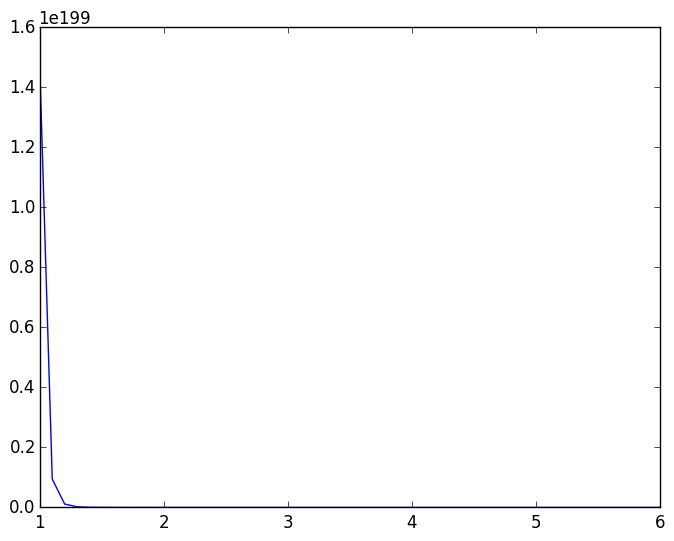

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f56d74bb710>

In [27]:
plot(1:0.1:6, [Z(T) for T in 1:0.1:6])

###- ¿Cómo sacarle jugo a la función de partición?

Recordemos que si $U$ es la energía interna del sistema entonces
\begin{equation}
U=\frac{1}{Z} \sum_i E_i e^{-\beta E_i}
\end{equation}
por lo tanto 
\begin{equation}
U=-\frac{1}{Z}\frac{\partial Z}{\partial\beta}=\frac{\partial \log(Z)}{\partial\beta}
\end{equation}
Podemos aproximar 
\begin{equation}
\frac{\partial Z}{\partial \beta}\approx \frac{\Delta Z}{\Delta \beta
}=\frac{\Delta Z}{\Delta (1/T)}
\end{equation}

Generamos un vector grandote de Z's 

In [28]:
TT=[1.2:0.1:6]
@time ZZ=[Z(T) for T in TT];

elapsed time: 0.004113265 seconds (798560 bytes allocated)


Encontramos la energía interna diferenciando el vector anterior

In [34]:
U=Float64[]
for i in 1:(length(TT)-1)
    push!(U,-(ZZ[i+1]-ZZ[i])/(ZZ[i+1]*(1/TT[i+1]-1/TT[i])))
end
U=[i-maximum(U) for i in U]

48-element Array{Any,1}:
 -54.2451   
 -36.7718   
 -26.5211   
 -20.1596   
 -15.984    
 -13.0953   
 -11.0023   
  -9.42479  
  -8.19619  
  -7.21293  
  -6.40804  
  -5.73663  
  -5.16762  
   ⋮        
  -0.608878 
  -0.539887 
  -0.474228 
  -0.411661 
  -0.351969 
  -0.294951 
  -0.24043  
  -0.188242 
  -0.138236 
  -0.0902752
  -0.0442351
   0.0      

###- Gráficad de la energía interna

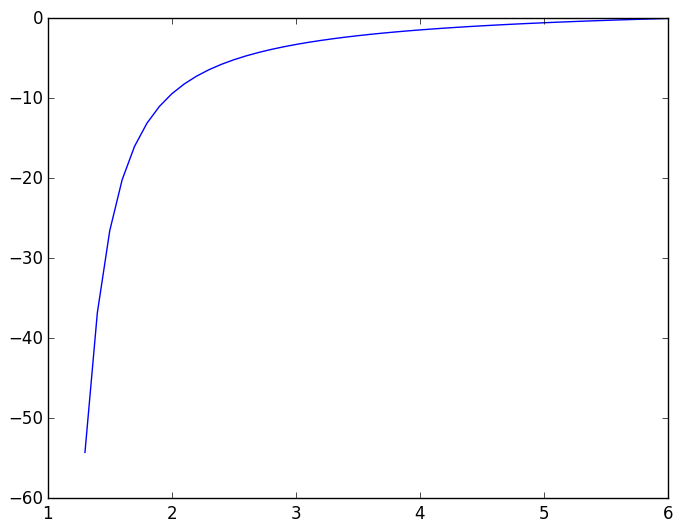

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f56d72ccc90>

In [35]:
plot(TT[2:end],U)

Calculamos la energía promedio respecto al tiempo usando el algoritmo de metropolis y graficamos

In [32]:
@time Umet=[energiaprom(5,5,T,1e5) for T in TT];

elapsed time: 17.004108897 seconds (4650082480 bytes allocated, 39.41% gc time)


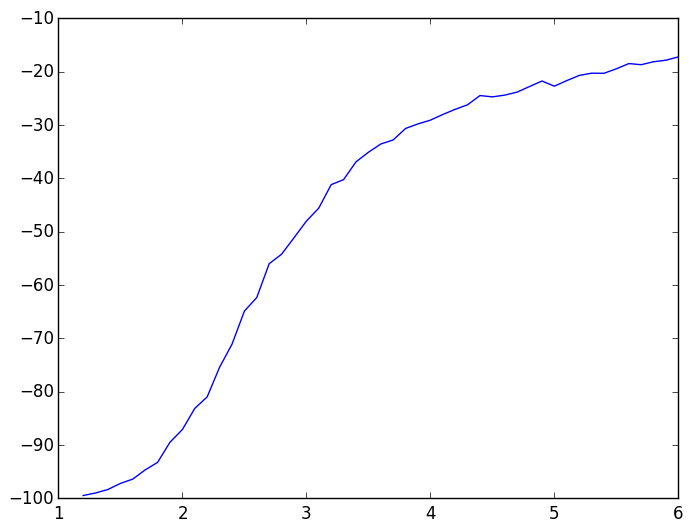

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f56d7395210>

In [33]:
plot(TT,Umet)

##- Conclusiones

- El algoritmo de Wang-Landau nos permite encontrar de manera "explícita" a la función de partición que no depende de la temperatura, lo cual es una ventaja respecto al algoritmo de Metropolis.

- Para arreglos pequeños el algoritmo de Wang-Landau es más eficiente en generar las energías internas a cualquier temperatura, ya que en el algoritmo de metropolis se tiene que calcular la caminata aleatoria para cada temperatura.

- Para arreglos grandes, el algoritmo de Wang-Landau es muy poco eficiente.